Importing all Libraries


In [75]:
import pandas as panda #Manipulação de dados
import numpy as np #Cálculos numéricos/arrays
import matplotlib.pyplot as plot #Graficos
import os #Para trabalhar com caminhos de arquivos
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split # Folds and Acc measurement
from sklearn.neighbors import KNeighborsClassifier # kNN
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_rel

Accessing and prepairing data


In [76]:
script_dir = os.path.abspath('')
csv_path = os.path.join(script_dir, 'Breast_cancer_dataset.csv')
data = panda.read_csv(csv_path)

#todas as linhas, todas as colunas exceto as duas primeiras
x = data.iloc[:, 2:-1]
#todas as linhas, somente segunda coluna
y = data.iloc[:, 1]


**1st Question -> Accuracies/Stability**

In [77]:

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

knn = KNeighborsClassifier(n_neighbors=5)
nb = GaussianNB()


knn_scores = cross_val_score(knn, x, y, cv=skf)
nb_scores = cross_val_score(nb, x, y, cv=skf)

knn_mean, knn_std = np.mean(knn_scores), np.std(knn_scores)
nb_mean, nb_std = np.mean(nb_scores), np.std(nb_scores)

print(f"kNN mean={knn_mean:.3f}, std={knn_std:.5f}")
print(f"Naïve Bayes mean={nb_mean:.3f}, std={nb_std:.5f}")

kNN mean=0.931, std=0.01692
Naïve Bayes mean=0.938, std=0.01664


From the result analysis, it is possible to conclude that kNN [std=0.01692] is less stable (higher standard deviation)
than the Naïve Bayes [std=0.01664].

Regarding accuracy, the Gaussian Naïve Bayes performs better with mean score of 93.8% as opposed from 93.1% of kNN.

**1st Question -> Accuracies/Stability with Min-Max Scaler pre-processor**

In [78]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
x_s = MinMaxScaler().fit_transform(x)  # default [0, 1]

knn_scaled_scores = cross_val_score(knn, x_s, y, cv=skf)
nb_scaled_scores = cross_val_score(nb, x_s, y, cv=skf)

knn_scaled_mean, knn_scaled_std = np.mean(knn_scaled_scores), np.std(knn_scaled_scores)
nb_scaled_mean, nb_scaled_std = np.mean(nb_scaled_scores), np.std(nb_scaled_scores)

print(f"kNN (scaled) mean={knn_scaled_mean:.3f}, std={knn_scaled_std:.5f}")
print(f"Naïve Bayes (scaled) mean={nb_scaled_mean:.3f}, std={nb_scaled_std:.5f}")

kNN (scaled) mean=0.970, std=0.01808
Naïve Bayes (scaled) mean=0.933, std=0.01619



From the result analysis, it is possible to conclude that kNN [std=0.01808] is still less stable (lower standard deviation)
than the Naïve Bayes [std=0.01619].

Regarding accuracy, there is a noticeable increase on kNN mean score to 97.0% and slight decrease on the GaussianNB to 93.3%.

This increase score on kNN is explained by the kNN reliance on distance measurements. When the data is not scaled,
features with larger numerical ranges dominate the distance computation, making the model less sensitive to other features.
The Min–Max scaler normalizes all features to the same range [0, 1], ensuring that each feature contributes equally to the distance metric. As a result, the model selects more appropriate neighbors, leading to better and more consistent predictions.

**1st Question -> Statistical Superiority**

In [79]:
t_stat, p_value = ttest_rel(knn_scaled_scores, nb_scaled_scores)
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 5.270430323647191
p-value: 0.006210329221932723


Using T-Test it is possible to conclude that with the p-value of 0.00621, the kNN model is statistically superior to the Gaussian Naïve Bayes (assuming default alpha = 0.05).

**2nd Question -> kNN (1/5/10/15/20/25) 70-30 train-test split**

In [80]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

# 70-30 split
X_train, X_test, y_train, y_test = train_test_split(
    x_s, y, test_size=0.3, random_state=1, stratify=y
)

# Different k values
k_values = [1, 5, 10, 15, 20, 25]

# Results
train_acc_uniform = []
test_acc_uniform = []
train_acc_distance = []
test_acc_distance = []

# Train models
for k in k_values:
    # Uniform weights
    knn_u = KNeighborsClassifier(n_neighbors=k, weights='uniform')
    knn_u.fit(X_train, y_train)
    train_acc_uniform.append(knn_u.score(X_train, y_train))
    test_acc_uniform.append(knn_u.score(X_test, y_test))

    # Distance weights
    knn_d = KNeighborsClassifier(n_neighbors=k, weights='distance')
    knn_d.fit(X_train, y_train)
    train_acc_distance.append(knn_d.score(X_train, y_train))
    test_acc_distance.append(knn_d.score(X_test, y_test))



Plotting the accuracy graph

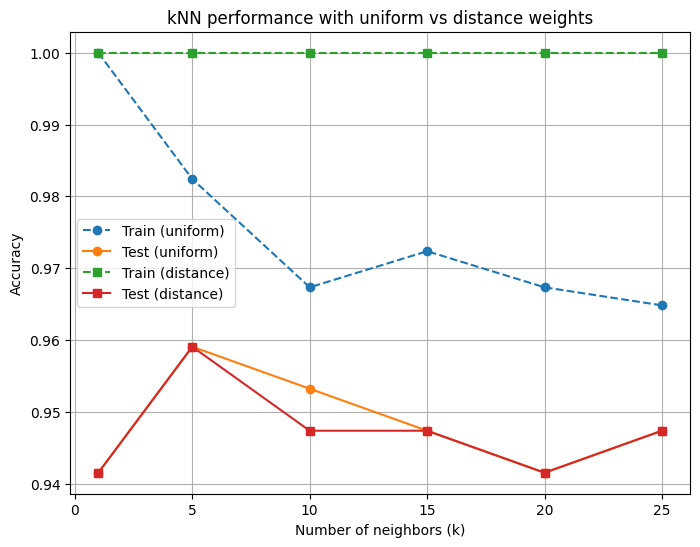

In [81]:
# Plot results
plot.figure(figsize=(8, 6))
plot.plot(k_values, train_acc_uniform, 'o--', label='Train (uniform)')
plot.plot(k_values, test_acc_uniform, 'o-', label='Test (uniform)')
plot.plot(k_values, train_acc_distance, 's--', label='Train (distance)')
plot.plot(k_values, test_acc_distance, 's-', label='Test (distance)')
plot.xlabel('Number of neighbors (k)')
plot.ylabel('Accuracy')
plot.title('kNN performance with uniform vs distance weights')
plot.legend()
plot.grid(True)
plot.show()


**2nd Question -> Graph Analysis**

Using a 70–30 train-test split, kNN classifiers were trained with k = {1, 5, 10, 15, 20, 25} using both uniform and distance-based weighting.
The train and test accuracies are plotted above.

The results show that for small k (k = 1), the model overfits, with high training accuracy and lower test accuracy. As k increases, both accuracies converge, indicating reduced variance but increased bias.

Distance weighting tends to yield considerable higher test accuracy, especially for small k, since closer neighbors are given more influence during prediction.

Given this data, the optimal k value is k=5, since it presents the highest measured test accuracy on both distance and uniform weights.


**3rd Question (extra analysis - confusion matrix)**

In [82]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(x)

# 70-30 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=1, stratify=y
)

knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
nb = GaussianNB()

# Train models
knn.fit(X_train, y_train)
nb.fit(X_train, y_train)

# Predict
y_pred_knn = knn.predict(X_test)
y_pred_nb = nb.predict(X_test)

# Confusion matrices
cm_knn = confusion_matrix(y_test, y_pred_knn, labels=['M','B'])
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=['M','B'])

print("Confusion Matrix - kNN (rows=actual, cols=predicted):")
print(cm_knn)
print("\nConfusion Matrix - Naïve Bayes (rows=actual, cols=predicted):")
print(cm_nb)

# False negatives = actual 'M' but predicted 'B'
fn_knn = cm_knn[0,1]
fn_nb = cm_nb[0,1]

print(f"\nFalse negatives - kNN: {fn_knn}")
print(f"False negatives - Naïve Bayes: {fn_nb}")

# Classification reports
print("\nClassification Report - kNN:")
print(classification_report(y_test, y_pred_knn, target_names=['M','B']))

print("\nClassification Report - Naïve Bayes:")
print(classification_report(y_test, y_pred_nb, target_names=['M','B']))

Confusion Matrix - kNN (rows=actual, cols=predicted):
[[ 58   6]
 [  1 106]]

Confusion Matrix - Naïve Bayes (rows=actual, cols=predicted):
[[ 54  10]
 [  2 105]]

False negatives - kNN: 6
False negatives - Naïve Bayes: 10

Classification Report - kNN:
              precision    recall  f1-score   support

           M       0.95      0.99      0.97       107
           B       0.98      0.91      0.94        64

    accuracy                           0.96       171
   macro avg       0.96      0.95      0.96       171
weighted avg       0.96      0.96      0.96       171


Classification Report - Naïve Bayes:
              precision    recall  f1-score   support

           M       0.91      0.98      0.95       107
           B       0.96      0.84      0.90        64

    accuracy                           0.93       171
   macro avg       0.94      0.91      0.92       171
weighted avg       0.93      0.93      0.93       171



**3rd Question -> Clinical setting deployment kNN vs Naïve Bayes**

Based on the tests ran, both kNN and Gaussian Naïve Bayes achieved high accuracies on the breast cancer dataset. However, the scaled kNN model achieved a mean accuracy of 97%, while the scaled Naïve Bayes model reached about 93%. Furthermore, the sci-py statistical testing (p-value = 0.006) indicated that the kNN improvement was significant.


1. Interpretability and transparency:

In medical diagnosis, clinicians should understand and trust the model’s reasoning. Naïve Bayes offers high interpretability — it provides explicit probabilities for each class and the contribution of each feature under the Gaussian assumption. In contrast, kNN can considered be considered non-interpretable: it predicts based on neighboring samples in the feature space, without providing a clear rule or explanation. Thus, from an interpretability standpoint, Naïve Bayes is preferable.

2. Computational cost and scalability:

kNN requires storing the entire training dataset and performing distance calculations for every new patient sample. This gets computationally expensive and memory-intensive, as more data is acquired/added to the training. On the other hand, Naïve Bayes stores a small number of parameters and performs predictions faster, making it preferable from a deployment and scalability perspective.

3. Predictive performance and robustness:

Although kNN achieved statistically higher accuracy after scaling, its performance can be sensitive to the choice of k, distance metric, and data scaling. Naïve Bayes is more robust to small data variations and noise but limited by its assumption of feature independence and normality. On structured and moderately sized medical datasets, this tradeoff often results in slightly lower accuracy but more stable deployment behavior. However, the recall metric is better on the kNN model,
specially on malignant diagnosis averaging a 99% recall (fewer false negatives -> safer on clinical/medical context).

Overall conclusion:

Unless the computing capabilities are the limiting factor and there are additional explainability tools (e.g., case-based reasoning or visualization of nearest neighbors), the kNN model would be the choice for this context, given the higher predictive performance and recall.

However, if computing limits are in order, the Naïve Bayes model can still be acceptable in a clinical environment due to its explainability, low computational cost, and ease of deployment.